### Скачивание постов

In [ ]:
%pip install vk_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 512.1 kB/s eta 0:00:00


In [ ]:
# Импортируем все нужные методы и библиотеки
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import spacy
import vk_api
from tqdm import tqdm_notebook
from wordcloud import WordCloud

In [ ]:
%%python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 697.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Создадим 2 отдельных списка с айди пабликов по аниме и по играм
group_ids_anime = {47949197, 61486033, 61768892, 86886389, 47}
group_ids_games = {63328642, 30387085, 64254966, 30602036, 60708045}

In [ ]:
def get_genre(group_id):
    return 'anime' if group_id in group_ids_anime else 'games'

In [ ]:
token = ''

vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

In [ ]:
# Создадим датасет с постами из пабликов, возьмем последние 500 из каждого
posts_data = []

for group_id in tqdm_notebook(list(group_ids_anime) + list(group_ids_games)):
    name = vk.groups.getById(group_id=group_id)[0]['name']
    genre = get_genre(group_id)
    count = 0
    offset = 0
    while count < 500:
        posts = vk.wall.get(owner_id=-group_id, count=100, offset=0)
        offset += 100
        valid_posts = [x for x in posts['items'] if x['text']]
        posts_data += [[genre, group_id, post['id'], post['text']] for post in valid_posts]
        count += len(valid_posts)

with open(f'posts_data.csv', 'w') as fout:
    csv.writer(fout).writerows(posts_data)

<ipython-input-8-f2dac266cb05>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for group_id in tqdm_notebook(list(group_ids_anime) + list(group_ids_games)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
header = ['genre', 'group_id', 'post_id', 'text'] # Дадим названия колонкам датасета
posts_data = pd.read_csv('posts_data.csv', names=header)

### Скачивание комментариев

In [ ]:
# Проведем похожие действия для скачивания комментариев под этими постами
comments_data = []

for _, row in tqdm_notebook(posts_data.iterrows()):
    post_id = row['post_id']
    group_id = row['group_id']
    genre = get_genre(group_id)
    try:
        comments = vk.wall.getComments(owner_id=-group_id, post_id=post_id, count=100)
        comments_data += [[group_id, genre, comment['text']] for comment in comments['items'] if comment['text']]
    except:
        continue

with open('comments_data.csv', 'w') as fout:
    csv.writer(fout).writerows(comments_data)

<ipython-input-41-19aa4bea9527>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm_notebook(posts_data.iterrows()):


0it [00:00, ?it/s]

In [ ]:

header = ['group_id', 'genre', 'text']
comment_data = pd.read_csv('comments_data.csv', names=header)

### Построение облаков слов

In [ ]:
comment_data.head(5) # Проверим датасет на корректный вид

,group_id,genre,text
0,61486033,anime,А есть галочка чтобы обновления вообще не уста...
1,61486033,anime,"Здравствуйте! Спасибо за создание сего ""шедевр..."
2,61486033,anime,Здравствуйте когда будет на iOS
3,61486033,anime,"Вопрос, планируется ли обновление с платными г..."
4,61486033,anime,А чего комментарии то удаляете? Вопрос актуаль...


In [ ]:
comment_data[comment_data['genre'] == 'anime'] # Столбец "genre" помогает нам отделять комментарии из пабликов про аниме от комментариев из пабликов про игры

,group_id,genre,text
0,61486033,anime,А есть галочка чтобы обновления вообще не уста...
1,61486033,anime,"Здравствуйте! Спасибо за создание сего ""шедевр..."
2,61486033,anime,Здравствуйте когда будет на iOS
3,61486033,anime,"Вопрос, планируется ли обновление с платными г..."
4,61486033,anime,А чего комментарии то удаляете? Вопрос актуаль...
...,...,...,...
16296,47,anime,Был сигмой который разваливает в соло всех. Вс...
16297,47,anime,1) планка для идеально слишком низка\n2) я бол...
16298,47,anime,Ууьеьу.
16299,47,anime,Гуль и человек с паразитом внутри себя


In [ ]:
nlp = spacy.load('ru_core_news_lg') # Используем инструментарий библиотеки spacy для предобработки текста

In [ ]:
def extract_lemmas(texts):
    lemmas = []
    for each in tqdm_notebook(texts):
        lemmas += [token.lemma_ for token in nlp(each)] # Проведем лемматизацию текста
    return lemmas

In [ ]:
# https://snipp.ru/seo/stop-ru-words
stop_words = open('stop-ru.txt', 'r', encoding='utf8')
stop_words = stop_words.read()
stop_words = set(stop_words.split('\n'))

In [ ]:
import re

def clean_lemmas(lemma):
    also_stop_words = {'роспись', 'чехол', 'дерево', 'гравировка', '-', 'ton', 'kazan', 'cryptoforum', 'криптоиндустрии', 'блокчейн', 'the', 'of'}
    if re.fullmatch(r'[\wа-яёй\-]+', lemma.lower()) and lemma not in stop_words | also_stop_words and not re.fullmatch(r'\d+', lemma): # Очистим текст от не-слов, знаков препинания и т.д.
        return True
    return False

In [ ]:
anime_comments_lemmas = list(filter(clean_lemmas, extract_lemmas(comment_data[comment_data['genre']=='anime']['text']))) # Создадим очищенные списки лемм

<ipython-input-48-7eef90facfa0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each in tqdm_notebook(texts):


  0%|          | 0/16301 [00:00<?, ?it/s]

In [ ]:
games_comments_lemmas = list(filter(clean_lemmas, extract_lemmas(comment_data[comment_data['genre']=='games']['text'])))

<ipython-input-48-7eef90facfa0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each in tqdm_notebook(texts):


  0%|          | 0/25353 [00:00<?, ?it/s]

In [ ]:
anime_posts_lemmas = list(filter(clean_lemmas, extract_lemmas(posts_data[posts_data['genre']=='anime']['text'])))

<ipython-input-48-7eef90facfa0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each in tqdm_notebook(texts):


  0%|          | 0/2682 [00:00<?, ?it/s]

In [ ]:
games_posts_lemmas = list(filter(clean_lemmas, extract_lemmas(posts_data[posts_data['genre']=='games']['text'])))

<ipython-input-48-7eef90facfa0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for each in tqdm_notebook(texts):


  0%|          | 0/2606 [00:00<?, ?it/s]

In [ ]:
# Визуализируем данные
def build_wordcloud(lemmas):
    lemmas = filter(lambda x: x not in stop_words and 'https' not in x and 'vk' not in x, lemmas)
    big_string = ' '.join(lemmas)
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, collocations=False).generate(big_string)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

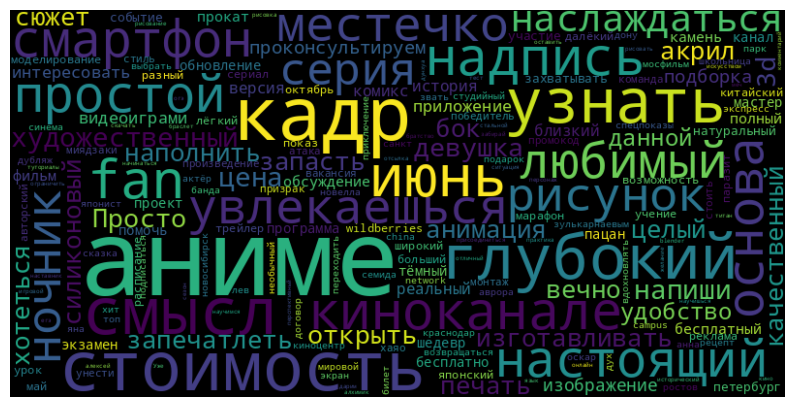

In [ ]:
build_wordcloud(anime_posts_lemmas)

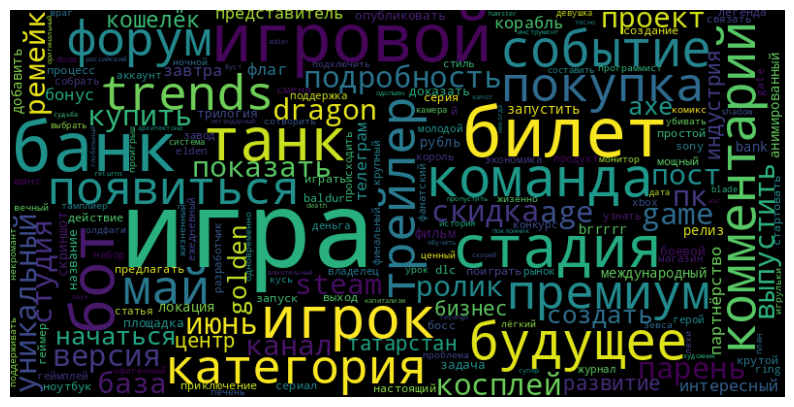

In [ ]:
build_wordcloud(games_posts_lemmas)

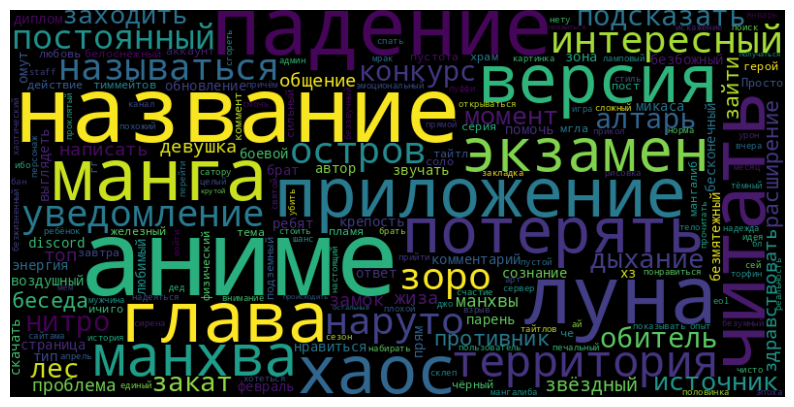

In [ ]:
build_wordcloud(anime_comments_lemmas)

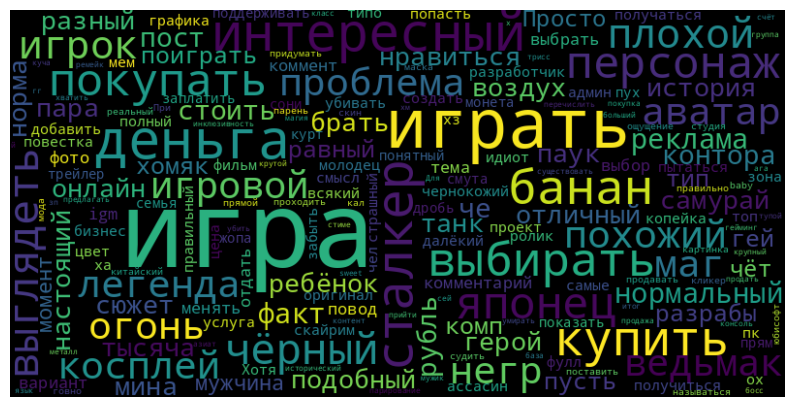

In [ ]:
build_wordcloud(games_comments_lemmas)

### Построение графиков

In [ ]:
from nltk import FreqDist

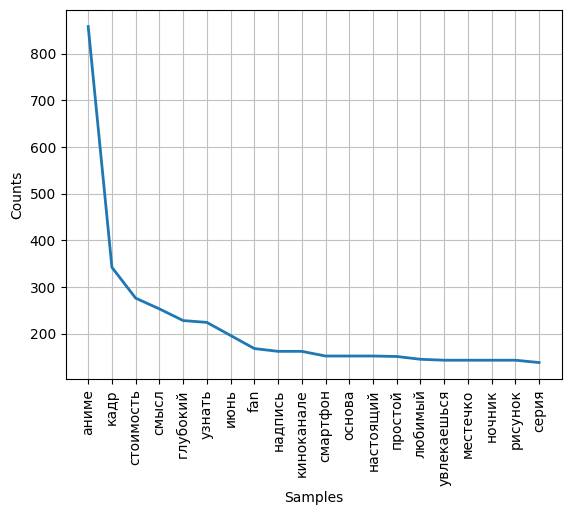

In [ ]:
fdist = FreqDist(anime_posts_lemmas)

fdist.plot(20, cumulative=False)
plt.show()

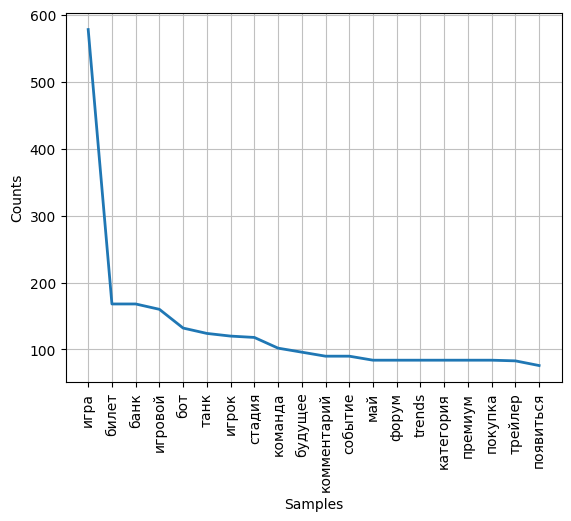

In [ ]:
fdist = FreqDist(games_posts_lemmas)

fdist.plot(20, cumulative=False)
plt.show()

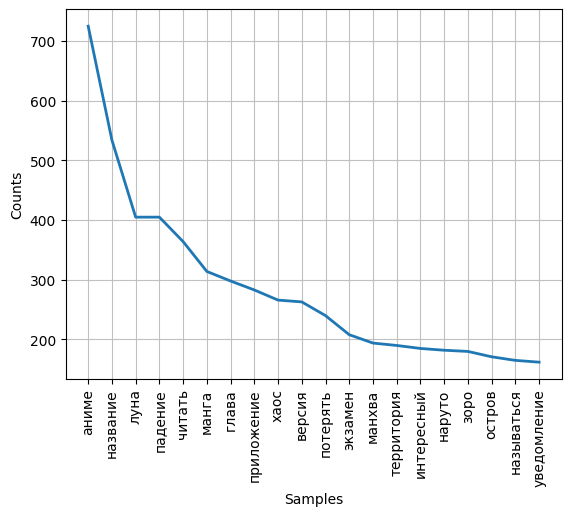

In [ ]:
fdist = FreqDist(anime_comments_lemmas)

fdist.plot(20, cumulative=False)
plt.show()

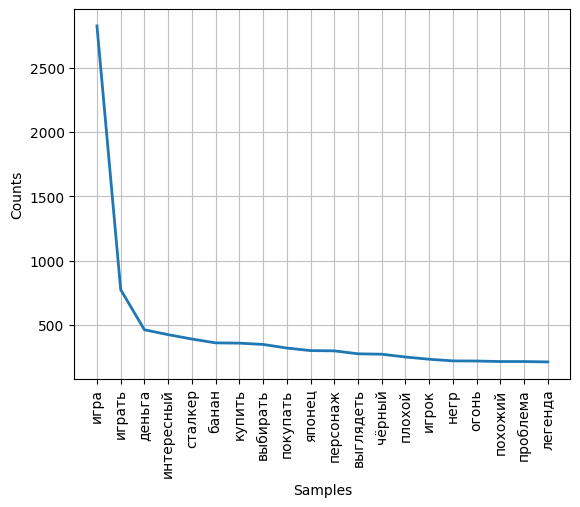

In [ ]:
fdist = FreqDist(games_comments_lemmas)

fdist.plot(20, cumulative=False)
plt.show()